In [39]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib.patches import Rectangle,Circle


matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 25
import os 


In [212]:
import matplotlib.transforms as transforms

def movie_maker_capsules(folder_name, X, Y, Theta, T0, Tf, BOX_SIZE, ROD_LENGTH=0.6, ROD_WIDTH=0.1,make_ffmpeg_movie=False,Tstart=0,del_pngs=False):
    fig, ax1 = plt.subplots(figsize=(5, 5))
    radius = ROD_WIDTH / 2

    for time in range(T0, Tf):
        ax1.clear()
        Xnow = X[time]
        Ynow = Y[time]
        Thetanow = Theta[time]

        for posx, posy, theta in zip(Xnow, Ynow, Thetanow):
            ux, uy = np.cos(theta), np.sin(theta)

            # Draw rectangle centered at the particle position
            rect_length = ROD_LENGTH - 2 * radius
            rect_center = (posx, posy)

            # Rectangle defined with bottom left at (center - half-length in x and half-width in y)
            rect = Rectangle((-rect_length / 2, -ROD_WIDTH / 2), rect_length, ROD_WIDTH,
                             facecolor='red', edgecolor='none',rotation_point=rect_center)

            # Apply rotation around (posx, posy)
            t = transforms.Affine2D().rotate_around(0, 0, theta).translate(posx, posy) + ax1.transData
            rect.set_transform(t)
            ax1.add_patch(rect)

            # Circular caps
            cap1_x = posx - (ROD_LENGTH / 2) * ux + radius*ux
            cap1_y = posy - (ROD_LENGTH / 2) * uy + radius*uy
            cap2_x = posx + (ROD_LENGTH / 2) * ux -  radius*ux
            cap2_y = posy + (ROD_LENGTH / 2) * uy -  radius*uy

            cap1 = Circle((cap1_x, cap1_y), radius=radius, facecolor='red', edgecolor='none')
            cap2 = Circle((cap2_x, cap2_y), radius=radius, facecolor='red', edgecolor='none')

            ax1.add_patch(cap1)
            ax1.add_patch(cap2)

        ax1.set_title(f'Time {time}', fontsize=12, loc='left')
        ax1.set_xlim(0, BOX_SIZE)
        ax1.set_ylim(0, BOX_SIZE)
        ax1.set_xticks([0, BOX_SIZE])
        # ax1.set_xticklabels([0, BOX_SIZE])
        ax1.set_yticks([])
        ax1.set_xlabel(r'$x$')
        ax1.set_ylabel(r'$y$')
        ax1.set_aspect('equal', adjustable='box')
        plt.tight_layout()
        plt.savefig(f"{folder_name}/positions_{time:03d}.png", dpi=200, bbox_inches='tight')

    plt.show()
    if make_ffmpeg_movie:
        os.system(f"ffmpeg -y -r 18 -start_number {Tstart:03d} -i '{folder_name}/positions_%03d.png' -vf 'crop=trunc(iw/2)*2:trunc(ih/2)*2'  -pix_fmt yuv420p {folder_name}/movie.mp4")
    if del_pngs:
        os.system(f"rm {folder_name}/positions_*.png")
 
        
    return None

In [178]:
def velocity_calc(X, Y, Dt, BOX_SIZE):
    Steps, N = X.shape
    # compute frame-to-frame shifts with PBC
    dX = X[1:] - X[:-1]
    dY = Y[1:] - Y[:-1]
    # minimal image
    dX = (dX + BOX_SIZE/2) % BOX_SIZE - BOX_SIZE/2
    dY = (dY + BOX_SIZE/2) % BOX_SIZE - BOX_SIZE/2

    Vx = dX / Dt
    Vy = dY / Dt
    V  = np.hypot(Vx, Vy)
    return Vx, Vy, V

def polar_OP(Theta):
    Px = np.mean(np.cos(Theta),axis=1)
    Py = np.mean(np.sin(Theta),axis=1)
    return np.sqrt(Px**2+Py**2),Px,Py

def nematic_OP(Theta):
    Qx = np.mean(np.cos(2*Theta),axis=1)
    Qy = np.mean(np.sin(2*Theta),axis=1)
    return np.sqrt(Qx**2+Qy**2),Qx,Qy

In [227]:
box=20
cutoff=4
Nparticles=1
T=800
Dt=0.01
rod_length=2
rod_radius=0.2
khardcore=0
kspring=2
rate=0.3
lo=10
kalign=12

folder_name=f"Dt_{Dt}_Nparticles_{Nparticles}_T_{T}_box_{box}_cutoff_{cutoff}_kalign_{kalign}_khardcore_{khardcore}_kspring_{kspring}_lo_{lo}_rate_{rate}_rod_length_{rod_length}_rod_radius_{rod_radius}"
positions_file = f"{folder_name}/particle_positions_{folder_name}.dat"
squared_disp_file = f"{folder_name}/squared_disp_{folder_name}.dat"

X,Y,Theta_b,Theta_p = np.loadtxt(positions_file, unpack=True)
Steps = len(X)//Nparticles
X = X.reshape((Steps, Nparticles))
Y = Y.reshape((Steps, Nparticles))
Theta_b = Theta_b.reshape((Steps,Nparticles))

Theta_p = Theta_p.reshape((Steps,Nparticles))
Vx,Vy,V = velocity_calc(X,Y,Dt,box)
P,Px,Py = polar_OP(Theta_b)
Q,Qx,Qy = nematic_OP(Theta_b)
Time = np.arange(0,Steps)*Dt
time,sd = np.loadtxt(squared_disp_file,unpack=True)
folder_name

'Dt_0.01_Nparticles_1_T_800_box_20_cutoff_4_kalign_12_khardcore_0_kspring_2_lo_10_rate_0.3_rod_length_2_rod_radius_0.2'

In [ ]:

movie_maker_capsules(folder_name,X,Y,Theta_b,0,Steps,box,rod_length,2*rod_radius,make_ffmpeg_movie=True,Tstart=0,del_pngs=True)
# ffmpeg -r 5 -start_number 000 -i 'positions_%03d.png' -vf "crop=trunc(iw/2)*2:trunc(ih/2)*2"  -pix_fmt yuv420p movie.mp4


# Mean Squared Displacement

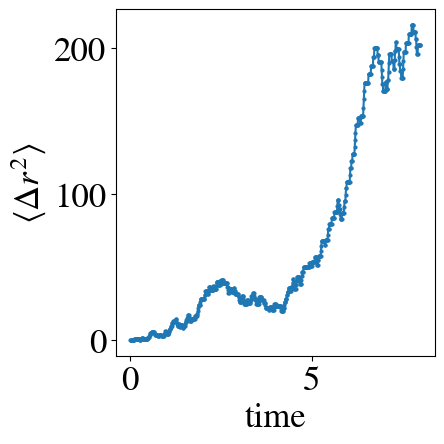

In [229]:

plt.figure(figsize=(5,5),layout='tight')
plt.plot(time,sd,lw=1.5,marker='o',ms=2)
plt.xlabel('time')
plt.ylabel(r'$\langle \Delta r^2 \rangle$')
# plt.xlim(0,0.4)
plt.show()


# Speed

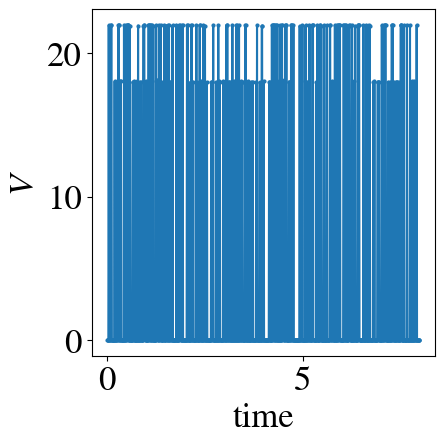

In [230]:
plt.figure(figsize=(5,5),layout='tight')
plt.xlabel('time')
plt.ylabel(r"$V$")
plt.plot(np.arange(0,Steps-1)*Dt,V,lw=1.5,marker='o',ms=2)
plt.show()


# Polar and Nematic Order

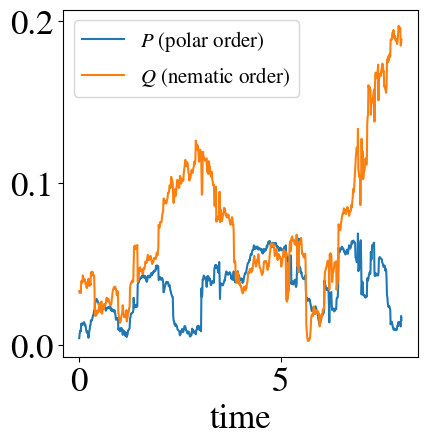

In [226]:
plt.figure(figsize=(5,5),layout='tight')
plt.xlabel('time')
# plt.ylabel(r"$P$")
plt.plot(Time,P,label=r'$P$ (polar order)',lw=1.5)
plt.plot(Time,Q,label=r'$Q$ (nematic order)',lw=1.5)
plt.legend(fontsize=15)
plt.show()